# CSC 2621 Final Project
**Authors:**  Thomas Benzshawel, Lucas Gral, Ben Paulson<Br/>
Section 131

[Associated GitHub Repository](https://github.com/ThomasBenzshawel/dasci-final)

[Associated Presentation Link](https://msoe365-my.sharepoint.com/:p:/g/personal/benzshawelt_msoe_edu/EWkYlq08PrZJo2wi0vCZnZ8B92eyS7vgOyK56dRwD4Ze7g?e=A6op41)

# Introduction

Lab about determining sentiment of Steam reviews.

TODO TODO TODOTODO TODO TODOTODO TODO TODOTODO TODO TODOTODO TODO TODOTODO TODO TODOTODO TODO TODOTODO TODO TODOTODO TODO TODOTODO TODO TODOTODO TODO TODOTODO TODO TODOTODO TODO TODOTODO TODO TODOTODO TODO TODO

In [36]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import matplotlib.pyplot as plt
nltk.download('stopwords')
nltk.download('punkt')
from collections import defaultdict
from sklearn.model_selection import train_test_split
import torch
from transformers import BertModel, BertTokenizer
import os
import csv
from scipy.stats import chi2_contingency
import numpy as np
from tqdm.notebook import tqdm

[nltk_data] Downloading package stopwords to /home/grall/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/grall/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [48]:
ALPHA_VALUE = 0.05

# Part 1: Data Exploration

### Part 1a: Data Importing & Description
The main dataset that will be used throughout this analysis is https://www.kaggle.com/datasets/andrewmvd/steam-reviews/code. This dataset contains 6.4 million reviews from the Steam platform; users are only able to review the game if they have bought and played the game. The reviews are from 2014 to 2017. The dataset contains the following columns: `app_id`, `app_name`, `review_text`, `review_score`, `review_votes`. The definition for each column is as follows:
* **app_id**: Unique ID of the game
* **app_name**: Name of the game
* **review_text**: Text of the review
* **review_score**: Score of the review (1 is positive, -1 is negative)
* **review_votes**: Number of votes the review received for 'helpfulness'

In this dataset, there are 6,417,106 reviews, reviewing 9,363 unique games. The average review score is 0.6395, meaning the average review of these 9,363 games is a positive review. The average review vote score is 0.147, meaning the community does not identify most reviews as being helpful by at least one person. Also, the average number of characters per review is 304, with the smallest being 1 and the largest being 8,873. Also, interestingly, there are over 8,000 reviews which are single-character, with "." being the most popular at 4,885 reviews.

In this dataset, there are 631 games with ratings of 100% based on the reviews given (which is a subset of the total reviews on Steam)

The datatypes of each of the different columns is as follows:
|id|Column|Dtype|
|---|---|---|
 0|app_id|int64 
 1|app_name|object
 2|review_text|object
 3|review_score|int64 
 4|review_votes|int64 

**memory usage:** 244.8+ MB

In [ ]:
review_data = pd.read_csv("dataset.csv")
review_data.columns

In [7]:
review_data.describe()

,app_id,review_score,review_votes
count,6.417106e+06,6.417106e+06,6.417106e+06
mean,2.274695e+05,6.394992e-01,1.472446e-01
std,1.260451e+05,7.687918e-01,3.543496e-01
min,1.000000e+01,-1.000000e+00,0.000000e+00
25%,2.018100e+05,1.000000e+00,0.000000e+00
50%,2.391600e+05,1.000000e+00,0.000000e+00
75%,3.056200e+05,1.000000e+00,0.000000e+00
max,5.653400e+05,1.000000e+00,1.000000e+00


### Part 1b: Importing Genre Data Using NLP to get the Genre of Each Game
In order to add the "genre" column for this dataset, an LLM was used to process the title of the game and assign a specific genre classification; there are 109 unique genres in this dataset. Because the LLM was trained up to 2021, and the training data was a majority of reputable sources across the internet, an assumption can be made that the model was able to accurately inference the genre from the title due to its knowledge of the title existing on game storefronts like Steam. Verificiation of 10 games resulted in 100% accuracy of the LLM's labeling.

Beyond this data collection, the genre titles were also cleaned manually. Manual cleaning was done to merge similar genre titles (ie "Zombie", "Zombies", "Zombies.", etc...), and to remove blank genre titles for games which could not be processed by the LLM. These games were unable to be processed either due to inappropriate language in the title or inappropriate language for the genre title ("Shoot-em up"). Further, non-manual cleaning can be seen in `Part 2: Cleaning & Preprocessing`

In [10]:
genre_data = pd.read_csv("steam_game_genre_manual_clean.csv")
genre_data.drop(columns=['number_of_reviews', 'Unnamed--0', 'review_score'], inplace=True)
genre_data = genre_data.drop_duplicates(subset=['app_name'])
genre_data.rename(columns={'answer':'genre'}, inplace=True)
genre_data.columns

Index(['app_name', 'genre'], dtype='object')

In [11]:
# Merge with the review_data dataframe to include genre with the games
review_data = review_data.merge(genre_data, on='app_name', how='left')
review_data

,app_id,app_name,review_text,review_score,review_votes,genre
0,10,Counter-Strike,Ruined my life.,1,0,Shooter
1,10,Counter-Strike,This will be more of a ''my experience with th...,1,1,Shooter
2,10,Counter-Strike,This game saved my virginity.,1,0,Shooter
3,10,Counter-Strike,• Do you like original games? • Do you like ga...,1,0,Shooter
4,10,Counter-Strike,"Easy to learn, hard to master.",1,1,Shooter
...,...,...,...,...,...,...
6417101,99910,Puzzle Pirates,I really ove this game but it needs somethings...,-1,0,Puzzle
6417102,99910,Puzzle Pirates,"Used to play Puzzel Pirates 'way back when', b...",-1,0,Puzzle
6417103,99910,Puzzle Pirates,"This game was aright, though a bit annoying. W...",-1,0,Puzzle
6417104,99910,Puzzle Pirates,"I had a nice review to recommend this game, bu...",-1,0,Puzzle


### Exploration 1: Average Review Score by Game
**Intro:** Group the dataset by game and calculate the average review score for each game within this dataset. Also get a count for the number of reviews for each game.

**Conclusion:** While an initial hypothesis was made that games with a higher number of reviews would not be present in either of the `review_score=1.0` or `review_score=-1.0` baskets, there are multiple games with over 100 reviews yet have only positive or negative reviews respectively. Also, looking at the visualization below for "Review Score vs Number of Reviews", it appears there is a slight trend for more reviews being given for good games. This makes sense since good games likely reach a larger audience, meaning there is a larger number of players who could potentially write a review for the game.

In [15]:
# Get the average review_score for each unique app_name
df = review_data[['app_name', 'review_score']].groupby('app_name').mean().reset_index().sort_values(by='review_score', ascending=False).reset_index(drop=True)

# Add a column called number_of_reviews to the dataframe
df['number_of_reviews'] = review_data[['app_name', 'review_score']].groupby('app_name').count().reset_index()['review_score']
df

,app_name,review_score,number_of_reviews
0,Discovering Colors - Animals,1.0,14
1,Fabric,1.0,26
2,Trigonarium,1.0,103
3,Aveyond 3-3: The Lost Orb,1.0,27
4,Aveyond 3-4: The Darkthrop Prophecy,1.0,63
...,...,...,...
9358,Angle of Attack,-1.0,2
9359,Retool,-1.0,1
9360,Ke-Tsu-No-Ana,-1.0,5
9361,3D Sprite Renderer and Convex Hull Editor,-1.0,190


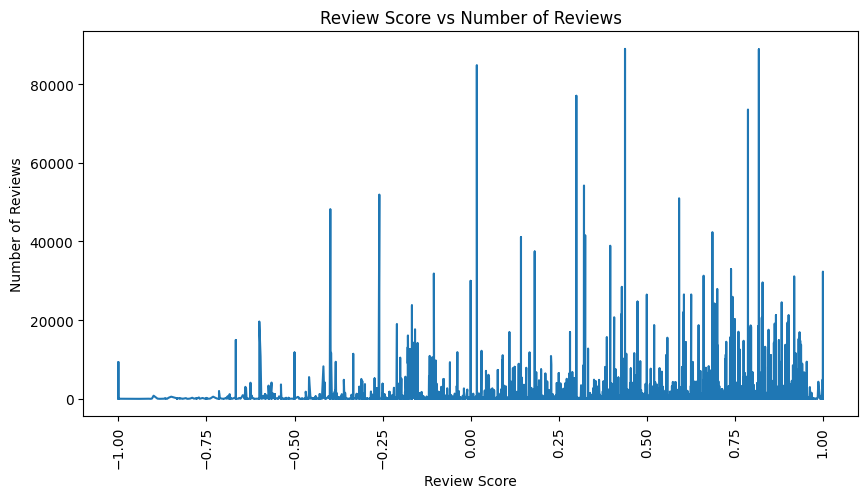

In [25]:
# Plot a bar chart of the review_score for each app_name and the y axis is the number of reviews
plt.figure(figsize=(10, 5))
plt.plot(df['review_score'], df['number_of_reviews'])
plt.xticks(rotation=90)
plt.xlabel('Review Score')
plt.ylabel('Number of Reviews')
plt.title('Review Score vs Number of Reviews')
plt.show()

### Exploration 2: Early Access Reviews
**Intro:** Early access games are typically buggy and not ready for full release; however, game developers release early access games to get feedback from the community. This is a double-edged sword because people who play Early Access Games are typically avid gamers or are following the development journey intently, meaning they may be less harsh in their review. However, becuase the game is typically glitchy, early access games may experience more negative reviews. This exploration will look at the average review score for early access games vs non-early access games and see if there is a noticeable difference.

**Conclusion:** Early access reviews are 15% of the total reviews in this dataset. The average review score for early access reviews is 58.16% whereas the average review score for non early access reviews is 65.04%. This is a difference of 6.88%. Further analysis will be done in `Part 3: Statistical Analysis` to determine if this difference is statistically significant.

In [40]:
# From the review_data dataframe, filter to only reviews which include "Early Access Review" in the review_text column
early_access_reviews = review_data.dropna(subset=['review_text'])
early_access_reviews = early_access_reviews[early_access_reviews['review_text'].str.contains("Early Access Review")]

# Get reviews which do not include "Early Access Review" in the review_text column
non_early_access_reviews = review_data.dropna(subset=['review_text'])
non_early_access_reviews = non_early_access_reviews[~non_early_access_reviews['review_text'].str.contains("Early Access Review")]

In [41]:
# Calculate the average review score for early_access_reviews. Don't group by app name
print("AVERAGE REVIEW SCORE FOR EARLY ACCESS: ", early_access_reviews[['review_score']].mean()[0])

# Calculate the average review score for review_data
print("AVERAGE REVIEW SCORE FOR ALL REVIEWS: ", non_early_access_reviews[['review_score']].mean()[0])

print("DIFFERENCE IN AVERAGE REVIEW SCORE: ", non_early_access_reviews[['review_score']].mean()[0] - early_access_reviews[['review_score']].mean()[0])

AVERAGE REVIEW SCORE FOR EARLY ACCESS:  0.5815624222375104
AVERAGE REVIEW SCORE FOR ALL REVIEWS:  0.6504070717316064
DIFFERENCE IN AVERAGE REVIEW SCORE:  0.06884464949409597


### Exploration 3: Term Frequency for Positive/Negative Reviews

(THOMAS)

### Using our stop word cleaning function

In [65]:
stopwords_list = set(stopwords.words('english'))

def remove_stop_words(text, stopwords):
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w in stopwords]
    return " ".join(filtered_sentence)

review_data_no_stopwords = review_data['review_text'].apply(lambda x: remove_stop_words(str(x), stopwords_list))

In [66]:
review_data_no_stopwords.head()

0                                        Ruined life .
1    This `` experience game '' type review , sayin...
2                          This game saved virginity .
3    • Do like original games ? • Do like games n't...
4                           Easy learn , hard master .
Name: review_text, dtype: object

In [67]:
review_data["stopwords_removed"] = review_data_no_stopwords

In [68]:
review_data.head()

,app_id,app_name,review_text,review_score,review_votes,genre,stopwords_removed
0,10,Counter-Strike,Ruined my life.,1,0,Shooter,Ruined life .
1,10,Counter-Strike,This will be more of a ''my experience with th...,1,1,Shooter,"This `` experience game '' type review , sayin..."
2,10,Counter-Strike,This game saved my virginity.,1,0,Shooter,This game saved virginity .
3,10,Counter-Strike,• Do you like original games? • Do you like ga...,1,0,Shooter,• Do like original games ? • Do like games n't...
4,10,Counter-Strike,"Easy to learn, hard to master.",1,1,Shooter,"Easy learn , hard master ."


In [70]:
genre_dict = defaultdict(list)
def count_words_in_genre(genre_dict, genre, text):
    word_tokens = word_tokenize(text)
    for word in word_tokens:
        genre_dict[genre].append(word)
    return genre_dict

In [71]:
updated_genre_dict = review_data.apply(lambda x: count_words_in_genre(genre_dict, x['genre'], x['stopwords_removed']), axis=1)
updated_genre_dict

0          {'Shooter': ['Ruined', 'life', '.', 'This', '`...
1          {'Shooter': ['Ruined', 'life', '.', 'This', '`...
2          {'Shooter': ['Ruined', 'life', '.', 'This', '`...
3          {'Shooter': ['Ruined', 'life', '.', 'This', '`...
4          {'Shooter': ['Ruined', 'life', '.', 'This', '`...
                                 ...                        
6417101    {'Shooter': ['Ruined', 'life', '.', 'This', '`...
6417102    {'Shooter': ['Ruined', 'life', '.', 'This', '`...
6417103    {'Shooter': ['Ruined', 'life', '.', 'This', '`...
6417104    {'Shooter': ['Ruined', 'life', '.', 'This', '`...
6417105    {'Shooter': ['Ruined', 'life', '.', 'This', '`...
Length: 6417106, dtype: object

# Part 2: Cleaning & Preprocessing


### Part 2a: General Data Cleaning

**Removal of "Stop Words". Stop words are general terms which are frequently cleaned from datasets when doing NLP for reduction in noise, focusing on only the most meaningful words without an attention mechanism, and to reduce the size of the dataset.**

In [2]:
# EXTREMELY LONG-RUNNING CELL (30 MIN); INSTEAD, LOAD FROM FILE
# stopwords_list = set(stopwords.words('english'))

# def remove_stop_words(text, stopwords):
#     word_tokens = word_tokenize(text)
#     filtered_sentence = [w for w in word_tokens if not w in stopwords]
#     return " ".join(filtered_sentence)

# review_data_no_stopwords = review_data['review_text'].apply(lambda x: remove_stop_words(str(x), stopwords_list))

review_data = pd.read_csv('dataset_with_genre_no-stopwords.csv')

In [73]:
# review_data.to_csv('dataset_with_genre_no-stopwords.csv')

### Part 2b: Specific Cleaning for Supervised Learning Models
**Normalization/standardization?**

In [3]:
# TODO: write full reasoning.
# For KNN, just keep arrays of stopwords_removed and review_score as binary class.

review_data

,Unnamed: 0,app_id,app_name,review_text,review_score,review_votes,genre,stopwords_removed
0,0,10,Counter-Strike,Ruined my life.,1,0,Shooter,Ruined life .
1,1,10,Counter-Strike,This will be more of a ''my experience with th...,1,1,Shooter,"This `` experience game '' type review , sayin..."
2,2,10,Counter-Strike,This game saved my virginity.,1,0,Shooter,This game saved virginity .
3,3,10,Counter-Strike,• Do you like original games? • Do you like ga...,1,0,Shooter,• Do like original games ? • Do like games n't...
4,4,10,Counter-Strike,"Easy to learn, hard to master.",1,1,Shooter,"Easy learn , hard master ."
...,...,...,...,...,...,...,...,...
6417101,6417101,99910,Puzzle Pirates,I really ove this game but it needs somethings...,-1,0,Puzzle,I really ove game needs somethings . It 's bas...
6417102,6417102,99910,Puzzle Pirates,"Used to play Puzzel Pirates 'way back when', b...",-1,0,Puzzle,"Used play Puzzel Pirates 'way back ' , Steam ...."
6417103,6417103,99910,Puzzle Pirates,"This game was aright, though a bit annoying. W...",-1,0,Puzzle,"This game aright , though bit annoying . When ..."
6417104,6417104,99910,Puzzle Pirates,"I had a nice review to recommend this game, bu...",-1,0,Puzzle,"I nice review recommend game , know n't purcha..."


In [9]:
knn_document_classes = .5 + review_data['review_score'].values/2 # 1 = positive, 0 = negative

In [105]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [103]:
knn_review_strs = (
    review_data['stopwords_removed']
    .astype(str)
    .apply(str.lower)
    .apply(str.split)
    .values
)

In [104]:
knn_review_strs

array([list(['ruined', 'life', '.']),
       list(['this', '``', 'experience', 'game', "''", 'type', 'review', ',', 'saying', 'things', 'like', '``', 'great', 'gameplay', "''", 'suit', 'something', 'i', "'ve", 'experienced', 'counter-strike', '.', 'here', 'go', ':', 'i', 'remember', 'back', '2002', 'i', 'friend', "'s", 'house', 'playing', 'game', '.', 'i', "n't", 'know', 'name', 'game', 'i', 'internet', 'find', '.', 'a', 'weeks', 'passed', 'another', 'friend', 'came', '.', 'he', "n't", 'computer', ',', 'brought', 'disc', 'game', '.', 'he', 'told', 'one', 'best', 'games', 'moment', 'i', 'knew', 'going', 'game', 'i', 'saw', 'friend', "'s", 'house', '.', 'when', 'i', 'saw', 'counter-strike', 'logo', 'i', 'filled', 'gamegasm', '(', '?', ')', 'i', 'happy', '.', 'i', 'playing', 'hardcore', '.', 'made', 'friends', ',', 'clans', ',', 'involved', 'communities', 'even', 'made', 'two', '.', 'counter-strike', 'first', 'game', 'i', 'played', 'competitively', 'experience', '.', 'playing', 'public', 

In [115]:
# Map unique terms to lists of bert tokens (ultimately to minimize dimensionality of terms)

knn_term_to_id = {}
for review in tqdm(knn_review_token_strs):
    for term in review:
        if term not in knn_term_to_id:
            knn_term_to_id[term] = tokenizer(term)['input_ids'][1:-1]

  0%|          | 0/6417106 [00:00<?, ?it/s]

In [120]:
# generate list of reviews in token-id form.
# Doing this by first tokenizing unique terms (as opposed to calling tokenizer on strings directly) is a ~12x to ~24x speedup for some reason

knn_review_toks = []

for review in tqdm(knn_review_token_strs):
    knn_review_toks += [[]]
    for term in review:
        knn_review_toks[-1] += knn_term_to_id[term]

  0%|          | 0/6417106 [00:00<?, ?it/s]

In [128]:
knn_unique_ids = np.unique(flatten(knn_term_to_id.values()))

In [ ]:
knn_term_freq = np.zeros()

In [136]:
print(
    'Storing the term-document metrix densely in memory would take',
    f'{len(knn_unique_ids)*len(review_data)*8 / 1_000_000_000:.2f}',
    'GB, so I\'m using a sparse matrix (dict of coordinate tuples).'
)

Storing the term-document metrix densely in memory would take 1457.76 GB, so I'm using a sparse matrix (dict of coordinate tuples).


In [143]:
term_document_frequency = {}

for i, review in enumerate(tqdm(knn_review_toks)):
    for tok in review:
        coord = (i, tok)
        term_document_frequency[coord] = term_document_frequency.get(coord, 0) + 1

  0%|          | 0/6417106 [00:00<?, ?it/s]

In [144]:
term_document_frequency

{(0, 9868): 1,
 (0, 2166): 1,
 (0, 1012): 1,
 (1, 2023): 1,
 (1, 1036): 4,
 (1, 3325): 3,
 (1, 2208): 10,
 (1, 1005): 16,
 (1, 2828): 1,
 (1, 3319): 1,
 (1, 1010): 13,
 (1, 3038): 1,
 (1, 2477): 1,
 (1, 2066): 5,
 (1, 2307): 2,
 (1, 11247): 3,
 (1, 4848): 1,
 (1, 2242): 1,
 (1, 1045): 26,
 (1, 2310): 3,
 (1, 5281): 1,
 (1, 4675): 7,
 (1, 1011): 10,
 (1, 4894): 6,
 (1, 1012): 25,
 (1, 2182): 1,
 (1, 2175): 4,
 (1, 1024): 3,
 (1, 3342): 1,
 (1, 2067): 3,
 (1, 2526): 1,
 (1, 2767): 3,
 (1, 1055): 4,
 (1, 2160): 2,
 (1, 2652): 4,
 (1, 1050): 5,
 (1, 1056): 5,
 (1, 2113): 3,
 (1, 2171): 1,
 (1, 4274): 1,
 (1, 2424): 2,
 (1, 1037): 1,
 (1, 3134): 1,
 (1, 2979): 1,
 (1, 2178): 1,
 (1, 2234): 1,
 (1, 2002): 2,
 (1, 3274): 1,
 (1, 2716): 1,
 (1, 5860): 1,
 (1, 2409): 1,
 (1, 2028): 1,
 (1, 2190): 1,
 (1, 2399): 5,
 (1, 2617): 1,
 (1, 2354): 1,
 (1, 2183): 2,
 (1, 2387): 2,
 (1, 2043): 1,
 (1, 8154): 1,
 (1, 3561): 1,
 (1, 12617): 1,
 (1, 2213): 1,
 (1, 1006): 1,
 (1, 1029): 1,
 (1, 1007): 1,
 (

In [145]:
knn_idfs = {}

# for each term, count documents with it
for doc, term in tqdm(term_document_frequency.items()):
    knn_idfs[term] = knn_idfs.get(term, 0) + 1
# log(num_docs/n_k)
N = len(knn_review_toks)
for k in tqdm(knn_idfs.keys()):
    knn_idfs[k] = np.log(N / knn_idfs[k])

  0%|          | 0/211984494 [00:00<?, ?it/s]

In [148]:
knn_idfs

{1: -3.3018482360823342,
 4: 0.7683632630412158,
 3: -0.044143815292465055,
 10: 3.1508827612257932,
 16: 4.387562486350912,
 13: 3.8472380639959507,
 5: 1.3734791139742442,
 2: -1.2340091630043455,
 26: 5.741819865382722,
 7: 2.234098600747949,
 6: 1.7978166361422283,
 25: 5.638690858669018,
 15: 4.208539121472739,
 8: 2.5736302317770816,
 12: 3.604310787174444,
 45: 7.3704778242634355,
 43: 7.241318599412403,
 32: 6.348579082608176,
 9: 2.8556982558261153,
 27: 5.837290314439735,
 11: 3.411405915183533,
 19: 4.885199956256731,
 34: 6.529102702094806,
 24: 5.500161899802882,
 14: 4.035351490593783,
 38: 6.876476100293784,
 39: 6.939917705265638,
 20: 5.000581140329627,
 21: 5.142514925483141,
 28: 5.9420751675504695,
 23: 5.410696853221059,
 22: 5.270912167463276,
 41: 7.1361103685709875,
 29: 6.063215955184156,
 17: 4.571145948940346,
 100: 10.24513216626419,
 60: 8.346697256796999,
 33: 6.446199278111435,
 37: 6.805501605944088,
 18: 4.702871526350735,
 31: 6.244520081704796,
 55: 8

In [152]:
# Apply tf*idf

knn_tf_idfs = {
    doc: term * knn_idfs[term]
    for doc,term in tqdm(term_document_frequency.items())
}

  0%|          | 0/211984494 [00:00<?, ?it/s]

In [153]:
knn_tf_idfs # This is used to clasify w/ knn.
# knn_tf_idfs[(doc, term)] = tf-idf of term in doc

{(0, 9868): -3.3018482360823342,
 (0, 2166): -3.3018482360823342,
 (0, 1012): -3.3018482360823342,
 (1, 2023): -3.3018482360823342,
 (1, 1036): 3.0734530521648633,
 (1, 3325): -0.13243144587739517,
 (1, 2208): 31.50882761225793,
 (1, 1005): 70.2009997816146,
 (1, 2828): -3.3018482360823342,
 (1, 3319): -3.3018482360823342,
 (1, 1010): 50.01409483194736,
 (1, 3038): -3.3018482360823342,
 (1, 2477): -3.3018482360823342,
 (1, 2066): 6.867395569871221,
 (1, 2307): -2.468018326008691,
 (1, 11247): -0.13243144587739517,
 (1, 4848): -3.3018482360823342,
 (1, 2242): -3.3018482360823342,
 (1, 1045): 149.28731649995078,
 (1, 2310): -0.13243144587739517,
 (1, 5281): -3.3018482360823342,
 (1, 4675): 15.638690205235644,
 (1, 1011): 31.50882761225793,
 (1, 4894): 10.78689981685337,
 (1, 1012): 140.96727146672546,
 (1, 2182): -3.3018482360823342,
 (1, 2175): 3.0734530521648633,
 (1, 1024): -0.13243144587739517,
 (1, 3342): -3.3018482360823342,
 (1, 2067): -0.13243144587739517,
 (1, 2526): -3.30184823

In [ ]:
# Cleaning 
Lucas Gral

In [ ]:
# Division for x and y in preparation for sentiment analysis training

### Part 2c: Specific Cleaning for Clustering

**Normalization/standardization?**

In [ ]:
# Cleaning
# Done already


In [ ]:
# Division for x and y in preparation for genre-classification training
train_test_split(review_data, test_size=0.2, random_state=42)

# Part 3: Statistical Analysis
We will utilize an alpha-value ($\alpha$) of 0.05 for all statistical tests.

In this section, we will be performinig different statistical analysis on the dataset to determine if there are any statistically significant relationships between different variables or groups of the dataset. This includes an analysis of the following:
* Relationship between `genre` and `review_score`
* Relationship between `review_score` and `review_length`
* Relationship between `review_length` and `review_votes`
* Statistical significance of the difference between the average review score of early access games vs non-early access games

Another relationship that should be recognized with this dataset is that the population we're pulling from does not meet the condition for creating a normally-distributed sample means graph. This is because of the following reasons:
* **Central Limit Theorem (CLT):** This condition can still be met. With the large number of reviews, a sample size of 30 is acceptable for creating a distribution of average review scores
* **Independence of Observations:** The CLT assumes that samples are also independent of each other. Since we see that the distribution is not normal, this condition may not be met. This could be because of the ["bandwagoning" effect](https://www.verywellmind.com/what-is-the-bandwagon-effect-2795895#:~:text=The%20bandwagon%20effect%20refers%20to%20the%20tendency%20of,other%20people%20will%20also%20hop%20on%20the%20bandwagon.) with game reviews.
* **Identical Distribution:** Samples must be drawn from the same distribution, meaning the scoring criteria for the game cannot change over time. This is condition is NOT met because games receive regular updates, so reviews may be more negative/positive during a certain timeframe based on the recency of a bad/good update.

For a graphic showcasing the distribution of average review scores, see the graphic below.

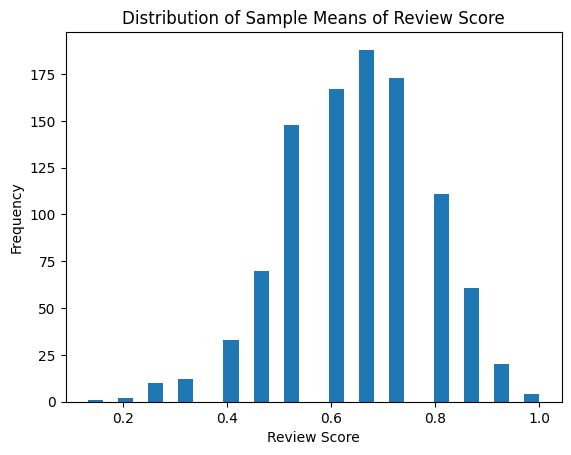

In [72]:
# Create a distribution of sample means of review_score where the sample size is 30 reviews
sample_means = []

for i in range(1000):
    sample = review_data.sample(n=30)
    sample_means.append(sample['review_score'].mean())

plt.hist(sample_means, bins=30)
plt.xlabel('Review Score')
plt.ylabel('Frequency')
plt.title('Distribution of Sample Means of Review Score')
plt.show()

### Part 3a: Chi-Squared Independence Test for Genre & Review Score
**Hypothesis:** (Adopt standard null hypothesis for Chi-squared test)

### Part 3b: Test of Correlation Between Review Score & Review Length
**Hypothesis:** 

### Part 3c: Test of Correlation Between Review Length & Review Helpfulness
**Hypothesis:** 

### Part 3d: Statistical Significance of Early Access Reviews
In `Exploration 2` of `Part 1: Data Exploration`, it was found that the average review score for early access reviews is 58.16% whereas the average review score for non early access reviews is 65.04%. This is a difference of 6.88%.
* **Null Hypothesis:** There is no significant difference between the average review score of early access games and non-early access games.
* **Alternative Hypothesis:** There is a significant difference between the average review score of early access games and non-early access games.

**Conclusion:** Since the distribution of review scores is not normal (the values are binary -1, 1), a statistical test not requiring normality must be used. Based on those covered in class, the best statistic test appears to be the Chi-Squared Test of independence. For these statistical tests, we continue to use an alpha-value ($\alpha$) of 0.05. Based on this tests, the p-value is 0.0, meaning we can reject the null hypothesis and accept the alternative hypothesis. This means there is a significant difference between the average review score of early access games and non-early access games.

In [58]:
early_access_counts = early_access_reviews['review_score'].value_counts().sort_index()
non_early_access_counts = non_early_access_reviews['review_score'].value_counts().sort_index()

In [60]:
# Create the contingency table as a DataFrame.
index = [-1, 1]  # The possible values for the review scores.
early_access_counts = early_access_counts.reindex(index, fill_value=0)
non_early_access_counts = non_early_access_counts.reindex(index, fill_value=0)

# Create the contingency table as a DataFrame.
contingency_table = pd.DataFrame({
    'Early Access': early_access_counts,
    'Non-Early Access': non_early_access_counts
})
contingency_table

,Early Access,Non-Early Access
review_score,,
-1,214398,941287
1,810357,4443759


In [63]:
# Perform the chi-squared test of independence.
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# Output the results.
print(f"Chi-squared Statistic: {chi2}")
print(f"P-value: {p_value}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected, "\n")

# Interpret the p-value
if p_value < ALPHA_VALUE:
    print("The difference in review scores between early access and non-early access is statistically significant.")
else:
    print("There is no statistically significant difference in review scores between early access and non-early access.")

Chi-squared Statistic: 6902.089980733008
P-value: 0.0
Degrees of Freedom: 1
Expected Frequencies:
[[ 184762.98752099  970922.01247901]
 [ 839992.01247901 4414123.98752099]] 

The difference in review scores between early access and non-early access is statistically significant.


# Part 4: Sentiment Analysis Experiments (Supervised Models)

### Part 4a: KKN w/ tfidf
Using the labels (positivity/negativity)

In [ ]:
LUCAS GRAL

### Part 4b: Fine-Tuning BERT
Using the labels (positivity/negativity), a BERT model will be fine-tuned

In [ ]:
LUCAS GRAL

# Part 5: Sentiment Analysis Experiments (Clustering)

**Why Use Clustering:** ______________________

**Why Use K-Means Clustering:** ______________________

**Justify the #Clusters:** (Elbow Method / Silhouette Coefficient)
   
    * Probably make a plot of the average silhouette score across the different cluster sizes

### Part 3a: K-Means Clustering
BERT Embeddings

In [12]:
model = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True,)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

100%|██████████| 231508/231508 [00:00<00:00, 2062702.06B/s]


In [25]:
def bert_text_preparation(text, tokenizer):
    """
    Preprocesses text input in a way that BERT can interpret.
    """
    marked_text = "[CLS] " + text + " [SEP]"
    tokenized_text = tokenizer.tokenize(marked_text)
    tokenized_text = tokenized_text[0:512]
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    segments_ids = [1]*len(indexed_tokens)
    
    # convert inputs to tensors
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensor = torch.tensor([segments_ids])
    
    return tokenized_text, tokens_tensor, segments_tensor

In [26]:
def get_bert_embeddings(tokens_tensor, segments_tensor, model):
    """
    Obtains BERT embeddings for tokens.
    """
    # gradient calculation is disabled
    with torch.no_grad():
        # obtain hidden states
        outputs = model(tokens_tensor, segments_tensor)
        hidden_states = outputs[2]    # concatenate the tensors for all layers
    # use "stack" to create new dimension in tensor
    token_embeddings = torch.stack(hidden_states, dim=0)    # remove dimension 1, the "batches"
    token_embeddings = torch.squeeze(token_embeddings, dim=1)    # swap dimensions 0 and 1 so we can loop over tokens
    token_embeddings = token_embeddings.permute(1,0,2)    # intialized list to store embeddings
    token_vecs_sum = []    # "token_embeddings" is a [Y x 12 x 768] tensor
    # where Y is the number of tokens in the sentence    
    # loop over tokens in sentence
    for token in token_embeddings:    # "token" is a [12 x 768] tensor    
        # sum the vectors from the last four layers
        sum_vec = torch.sum(token[-4:], dim=0)
        token_vecs_sum.append(sum_vec)
        
    return token_vecs_sum

In [29]:
from collections import OrderedDict

context_embeddings = []
context_tokens = []
for sentence in review_data['review_text'].head(10):
    tokenized_text, tokens_tensor, segments_tensors = bert_text_preparation(sentence, tokenizer)
    list_token_embeddings = get_bert_embeddings(tokens_tensor, segments_tensors, model)  # make ordered dictionary to keep track of the position of each   word
    tokens = OrderedDict()  # loop over tokens in sensitive sentence
    
    for token in tokenized_text[1:-1]:
        # keep track of position of word and whether it occurs multiple times
        if token in tokens:
            tokens[token] += 1
        else:
            tokens[token] = 1  # compute the position of the current token
        token_indices = [i for i, t in enumerate(tokenized_text) if t == token]
        current_index = token_indices[tokens[token]-1]  # get the corresponding embedding
        token_vec = list_token_embeddings[current_index]

        # save values
        context_tokens.append(token)
        context_embeddings.append(token_vec)

In [32]:
filepath = os.path.join('')
name = 'metadata_small.tsv'

with open(os.path.join(filepath, name), 'w+') as file_metadata:
    for i, token in enumerate(context_tokens):
        file_metadata.write(token + '\n')
        name = 'embeddings_small.tsv'
        
        with open(os.path.join(filepath, name), 'w+') as tsvfile:
            writer = csv.writer(tsvfile, delimiter='\t')
            for embedding in context_embeddings:
                writer.writerow(embedding.numpy())

# Visualizing the embedding in TensorBoard
https://projector.tensorflow.org/

### Part 3b: K-Means Clustering
Term Frequency Space

In [ ]:
THOMAS BENZSHAWEL

# Part 6: Evaluation

### Part 6a: Evaluating Supervised Models

In [ ]:
LUCAS GRAL

### Part 6b: Evaluating Clustering Models

In [ ]:
THOMAS BENZSHAWEL

# Conclusion
TODO TDOO TDODO TODO TDOO TDODO TODO TDOO TDODO TODO TDOO TDODO TODO TDOO TDODO TODO TDOO TDODO TODO TDOO TDODO TODO TDOO TDODO TODO TDOO TDODO TODO TDOO TDODO TODO TDOO TDODO TODO TDOO TDODO TODO TDOO TDODO TODO TDOO TDODO TODO TDOO TDODO TODO TDOO TDODO TODO TDOO TDODO TODO TDOO TDODO TODO TDOO TDODO TODO TDOO TDODO TODO TDOO TDODO TODO TDOO TDODO TODO TDOO TDODO TODO TDOO TDODO TODO TDOO TDODO TODO TDOO TDODO TODO TDOO TDODO TODO TDOO TDODO TODO TDOO TDODO TODO TDOO TDODO TODO TDOO TDODO TODO TDOO TDODO TODO TDOO TDODO TODO TDOO TDODO TODO TDOO TDODO TODO TDOO TDODO 

# Contribution Statement
* **Lucas Gral:**
* **Thomas Benzshawel:**
* **Ben Paulson:**